# Notebook for learning from data coursework 2022

In [308]:
# import our libraries that we will be using to investigate the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MaxAbsScaler

## load out csv data into a pandas dataframe so that we can manipulate it

In [309]:
dataframe = pd.read_csv("AT_T_SBC_Stock_Price_Data_2000_2020.csv")

# filter out the columns we dont care about
important_cols = ["DATE", "OPENPRC", "VOL", "BIDLO", "ASKHI", "PRC"]
dataframe = dataframe[important_cols]

In [310]:
def gen_model(model, data, cols, time_series_past, time_series_future, normalize=False):
    
    #col_selection = cols_to_include.copy()
    col_selection = ["DATE"]
    for i in range(1, time_series_past):
        for col in cols:
            data[col + str(i) + "DAY"] = data[col].shift(periods=i)
            col_selection.append(col + str(i) + "DAY")

    data["PRC" + str(time_series_future) + "DAY"] = data["PRC"].shift(-time_series_future)

    if time_series_future == 0:
        cleaned_data = data.iloc[time_series_past:]
    else:
        cleaned_data = data.iloc[time_series_past:-time_series_future]

    X = cleaned_data[col_selection]
    if time_series_future == 0:
        Y = cleaned_data["PRC"]
    else:
        Y = cleaned_data["PRC" + str(time_series_future) + "DAY"]

    if normalize:
        X = (X - X.mean()) / X.std()

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

    model.fit(x_train, y_train)

    # predict our testing data
    predictions = model.predict(x_test)

    total_error = 0

    # itterate our predictions and calculate the mean square error
    for i in range(len(predictions)):
        total_error += pow(predictions[i] - y_test.array[i], 2)

    print("number of predictions:", len(y_test))

    plt.plot(x_test["DATE"], predictions, "bo", markersize=0.3)
    plt.plot(x_test["DATE"], y_test, "ro", markersize=0.3)
    plt.title(str(model) + " predicting " + str(time_series_future) + " days into the future")
    plt.show()

    # check our mean square error for our models
    print("total error squared linear: ", total_error, "MSE:", total_error / len(y_test))
    print("total error squared lasso: ", total_error, "MSE:", total_error / len(y_test))

    cross_val_linear = cross_val_score(model, X, Y)
    print("cross validation score:", cross_val_linear)

## set up some variables that we will use to pre-process our data

In [311]:
# set the depth of our time series here
time_series_depth = 5

# add all the extra data into each column
important_cols = ["DATE", "OPENPRC", "VOL", "BIDLO", "ASKHI", "PRC"]

for i in range(1, time_series_depth):
    for col in important_cols:
        dataframe[col + str(i) + "DAY"] = dataframe[col].shift(periods=i)


## take a look at the results when we include all the important data

number of predictions: 1585


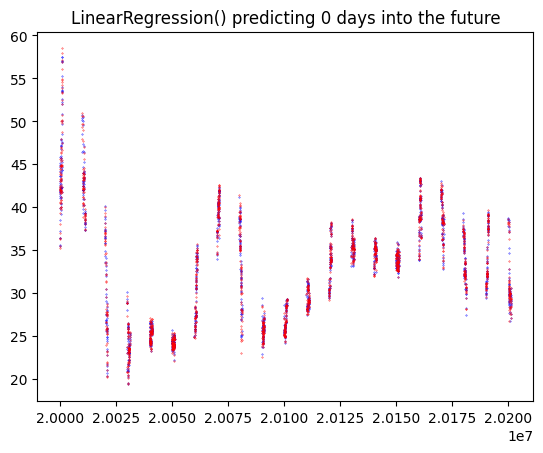

total error squared linear:  448.4689717488058 MSE: 0.28294572350082386
total error squared lasso:  448.4689717488058 MSE: 0.28294572350082386
cross validation score: [0.99209734 0.996042   0.97715208 0.9811265  0.98390535]
number of predictions: 1585


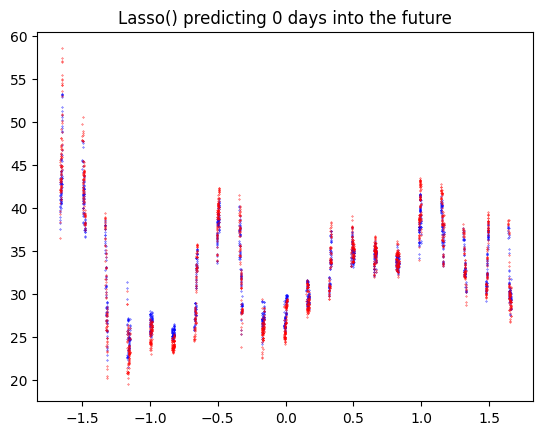

total error squared linear:  2125.0705656659466 MSE: 1.3407385272340357
total error squared lasso:  2125.0705656659466 MSE: 1.3407385272340357
cross validation score: [0.91981777 0.96545127 0.88683643 0.92004373 0.96118554]


In [312]:

gen_model(LinearRegression(), dataframe, important_cols, time_series_past=5, time_series_future=0)
gen_model(Lasso(), dataframe, important_cols, time_series_past=5, time_series_future=0)

## check if reducing the amount of data will change our prediction quality

number of predictions: 1585


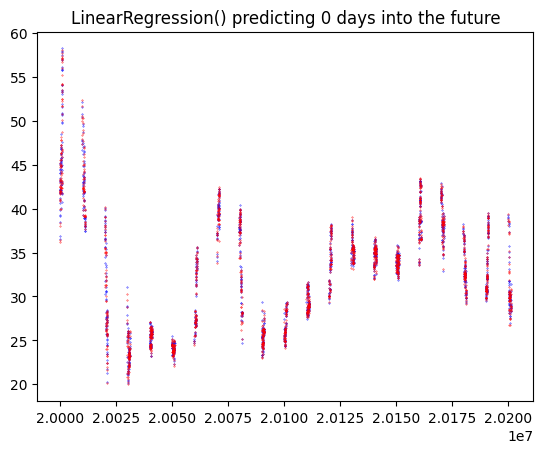

total error squared linear:  592.0446847310324 MSE: 0.37352976954639266
total error squared lasso:  592.0446847310324 MSE: 0.37352976954639266
cross validation score: [0.99206607 0.99608988 0.97682677 0.98129058 0.98371764]
number of predictions: 1585


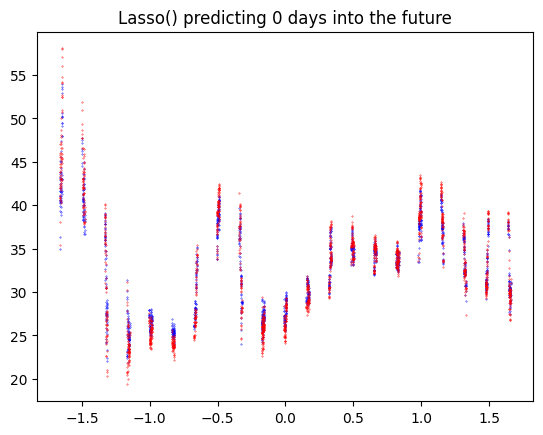

total error squared linear:  1993.257664695445 MSE: 1.257575813687978
total error squared lasso:  1993.257664695445 MSE: 1.257575813687978
cross validation score: [0.92028434 0.96559334 0.88836032 0.92793912 0.96290317]


In [313]:
cols_to_include = ["PRC", "VOL", "BIDLO"]
gen_model(LinearRegression(), dataframe, cols_to_include, time_series_past=5, time_series_future=0)
gen_model(Lasso(), dataframe, cols_to_include, time_series_past=5, time_series_future=1)

## can we predict more into the future than one day?

number of predictions: 1582


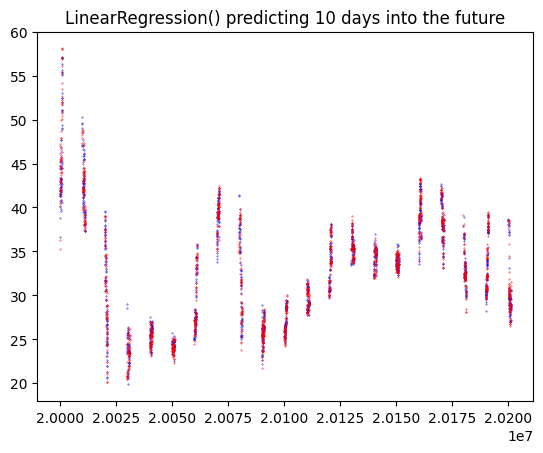

total error squared linear:  4181.0708954859465 MSE: 2.642901956691496
total error squared lasso:  4181.0708954859465 MSE: 2.642901956691496
cross validation score: [0.9341999  0.96357501 0.82312917 0.82617309 0.85882321]
number of predictions: 1582


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.981e+03, tolerance: 1.613e+01
  model = cd_fast.enet_coordinate_descent(


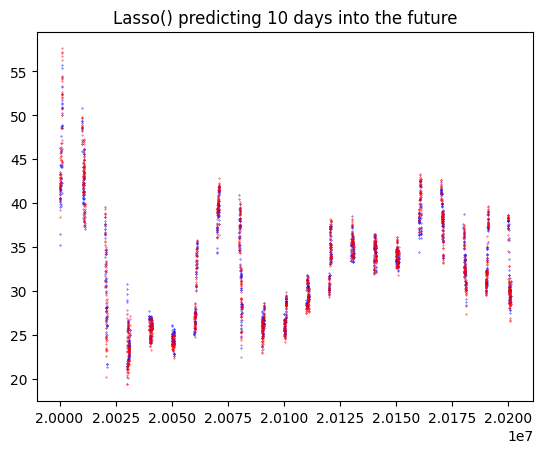

total error squared linear:  4346.01504776732 MSE: 2.7471650112309227
total error squared lasso:  4346.01504776732 MSE: 2.7471650112309227


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.311e+03, tolerance: 1.153e+01
  model = cd_fast.enet_coordinate_descent(
/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.005e+04, tolerance: 1.768e+01
  model = cd_fast.enet_coordinate_descent(
/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.903e+

cross validation score: [0.92948129 0.96153959 0.8194685  0.82219488 0.85826154]


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.033e+04, tolerance: 2.125e+01
  model = cd_fast.enet_coordinate_descent(
/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.140e+03, tolerance: 2.082e+01
  model = cd_fast.enet_coordinate_descent(


In [314]:
# 10 days into the future
gen_model(LinearRegression(), dataframe, cols_to_include, time_series_past=5, time_series_future=10)
gen_model(Lasso(), dataframe, cols_to_include, time_series_past=5, time_series_future=10)